In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
import os
import cv2
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121,VGG19
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import layers, models
import random
import torch
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2024-07-17 22:15:21.980353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 22:15:21.980474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 22:15:22.220672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set Random Seed

In [3]:
def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_random_seed(42)
batch_size = 16

# Utility Functions

In [3]:
def resize_images(images, target_size=(224, 224, 3)):
    resized_images = [cv2.resize(img, target_size[:2]) for img in images]
    resized_images = np.array(resized_images, dtype=np.float32)
    # Min-Max normalization
    min_val = np.min(resized_images)
    max_val = np.max(resized_images)
    resized_images = (resized_images - min_val) / (max_val - min_val)
    return resized_images

def remove_scratches(image):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    median_filtered = cv2.medianBlur(image, 9)
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(median_filtered, cv2.MORPH_CLOSE, kernel)
    return morphed

def sharpen_image(image):
    # Create a kernel for sharpening
    kernel = [[-1, -1, -1],
              [-1,  9, -1],
              [-1, -1, -1]]
    kernel = np.array(kernel)
    # Apply the kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)

    return sharpened_image

def cropImg(img):
    # Load image
    #img = cv2.imread(r'%s'%path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get image height and width
    height, width = gray.shape[:2]

    col= width//2
    tr=0
    br=0

    # Scan downward
    for toprow in range(height):
        # Check if the pixel is white
        if gray[toprow,col] < 185:
            tr=toprow
            break

    # Scan upward
    for brow in range(height-1,0,-1):
        br += 1
        if gray[brow,col] < 185:
            break


    row=height//2
    lc=0
    rc=0

    # Scanning from the left
    for lcol in range(width):
        if gray[row,lcol] < 185:
            lc=lcol
            break

    # Scanning from the right
    for rcol in range(width-1,0,-1):
        rc += 1
        if gray[row,rcol] < 185:
            break

    cropped_image = img[tr:height-br, lc:width-rc]
    return cropped_image

def adjust_gamma(image, gamma=1.0):
    # Ensure the input image is in float32 format
    image = image.astype(np.float32) / 255.0
    # Apply gamma correction
    gamma_corrected = np.power(image, 1/gamma)
    # Convert the gamma corrected image back to uint8
    gamma_corrected = (gamma_corrected * 255).astype(np.uint8)
    return gamma_corrected

def remS(image):
    res = remove_scratches(image)
    ress = sharpen_image(res)
    return ress

def apply_CLAHE(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Apply CLAHE to grayscale image
    clahe_image = clahe.apply(image)
    # Convert CLAHE-enhanced grayscale image back to BGR format
    clahe_bgr_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)
    return clahe_bgr_image

data_augmentation = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
)

def augment_data(data, labels, augmentation_factor=1):
    augmented_data = []
    augmented_labels = []

    for i in range(len(data)):
        img = data[i]
        label = labels[i]

        # Apply augmentation_factor times augmentation for each image
        for _ in range(augmentation_factor):
            augmented_img = data_augmentation.random_transform(img)
            augmented_data.append(augmented_img)
            augmented_labels.append(label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    combined_data = np.concatenate((data, augmented_data), axis=0)
    combined_labels = np.concatenate((labels, augmented_labels), axis=0)

    return combined_data, combined_labels

# Load and Preprocess Data

In [4]:
# Set the paths to your 'apical' and 'normal' folders
apical_folder = '/kaggle/input/no-scratches-gp-dataset/no_scratches_dataset/Apical'
normal_folder = '/kaggle/input/no-scratches-gp-dataset/no_scratches_dataset/Normal'


apical_images = [cv2.imread(os.path.join(apical_folder, img)) for img in sorted(os.listdir(apical_folder))]
normal_images = [cv2.imread(os.path.join(normal_folder, img)) for img in sorted(os.listdir(normal_folder))]

apical_folder2 = '/kaggle/input/cbctds/FCBCT/apical'
normal_folder2 = '/kaggle/input/cbctds/FCBCT/normal'

# Combine data from both folders
apical_images2 = [cv2.imread(os.path.join(apical_folder2, img)) for img in sorted(os.listdir(apical_folder2))]
normal_images2 = [cv2.imread(os.path.join(normal_folder2, img)) for img in sorted(os.listdir(normal_folder2))]
apical_images = apical_images + apical_images2
normal_images = normal_images + normal_images2
print("len of apical data:",len(apical_images))
print("len of normal data:",len(normal_images))

apical_images = [cropImg(image) for image in apical_images]
normal_images = [cropImg(image) for image in normal_images]

target_size = (256, 256, 3)
apical_images_resized = resize_images(apical_images, target_size)
normal_images_resized = resize_images(normal_images, target_size)

# Assuming labels are binary (0 for 'apical' and 1 for 'normal')
apical_labels = np.zeros(len(apical_images_resized), dtype=int)
normal_labels = np.ones(len(normal_images_resized), dtype=int)

apical_train, apical_test, apical_train_labels, apical_test_labels = train_test_split(apical_images_resized, apical_labels, test_size=0.2, random_state=42)
normal_train, normal_test, normal_train_labels, normal_test_labels = train_test_split(normal_images_resized, normal_labels, test_size=0.2, random_state=42)
test_data = np.concatenate((apical_test, normal_test), axis=0)
print("len of test data:",len(test_data))
print("len of apical train data:",len(apical_train))
print("len of normal train data:",len(normal_train))
test_labels = np.concatenate((apical_test_labels, normal_test_labels), axis=0)

len of apical data: 790
len of normal data: 599
len of test data: 278
len of apical train data: 632
len of normal train data: 479


# Apply SMOTE

In [5]:
unbalanced_traindata = np.concatenate((apical_train,normal_train),axis=0)
unbalanced_labels = np.concatenate((apical_train_labels,normal_train_labels),axis=0)
print("Number of unbalanced train data:", len(unbalanced_traindata))

# Flatten images to feature vectors
num_samples, height, width, channels = unbalanced_traindata.shape
feature_vectors = unbalanced_traindata.reshape((num_samples, height * width * channels))
# Apply SMOTE to balance the dataset

sm = BorderlineSMOTE(random_state=42,sampling_strategy='minority')
balanced_feature_vectors, balanced_labels = sm.fit_resample(feature_vectors, unbalanced_labels)

# If needed, convert balanced feature vectors back to image format
num_balanced_samples = len(balanced_labels)
balanced_traindata = balanced_feature_vectors.reshape((num_balanced_samples, height, width, channels))
print("Number of balanced train data:", len(balanced_traindata))

# ---check
# Separate balanced images into apical and normal classes
balanced_apical_images = balanced_traindata[balanced_labels == 0]
balanced_normal_images = balanced_traindata[balanced_labels == 1]
# Verify the number of images in each class
print("Number of balanced apical images:", len(balanced_apical_images))
print("Number of balanced normal images:", len(balanced_normal_images))

train_data, train_labels = augment_data(balanced_traindata, balanced_labels, augmentation_factor=2)
print("len after augmentaion: ",len(train_data))
print("Combining is done! \nresized with (256, 256, 3)!")
print("processing is done")

Number of unbalanced train data: 1111
Number of balanced train data: 1264
Number of balanced apical images: 632
Number of balanced normal images: 632
len after augmentaion:  3792
Combining is done! 
resized with (256, 256, 3)!
processing is done


# DenseNet121 Model with Custom Layers and Exponential Decay Learning Rate

In [6]:
densenet = DenseNet121(weights='imagenet',
                      include_top=False,
                      input_shape=target_size,
                      classes=2)
x = densenet.output
x = Flatten()(x)
x = Dropout(0.6, seed=42)(x)
pred=tf.keras.layers.Dense(2, activation='softmax')(x)
model= tf.keras.Model(inputs=densenet.input, outputs=pred)

early_layers = 100
# Freezing layers of the base model
for layer in densenet.layers[:early_layers]:
    layer.trainable = False

# Define an exponential decay learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate, 
    decay_steps=100000, 
    decay_rate=0.8, 
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training and Validation

Epoch 1/80


I0000 00:00:1721254842.557709     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721254842.692464     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5079 - loss: 1.5782   

W0000 00:00:1721254956.182818     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.5081 - loss: 1.5772 - val_accuracy: 0.5165 - val_loss: 1.3196
Epoch 2/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 233ms/step - accuracy: 0.5939 - loss: 0.9993 - val_accuracy: 0.5889 - val_loss: 0.9474
Epoch 3/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.6674 - loss: 0.7858 - val_accuracy: 0.5797 - val_loss: 0.9973
Epoch 4/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.6716 - loss: 0.6810 - val_accuracy: 0.5692 - val_loss: 1.2943
Epoch 5/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.6758 - loss: 0.6276 - val_accuracy: 0.5837 - val_loss: 1.3750
Epoch 6/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.7064 - loss: 0.5870 - val_accuracy: 0.5692 - val_loss: 1.4758
Epoch 7/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.7202 - loss: 0.5793 - val_accuracy: 0.5731 - val_loss: 2.3510
Epoch 8/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.7237 - loss: 0.5152 - val_accuracy: 0.5758 

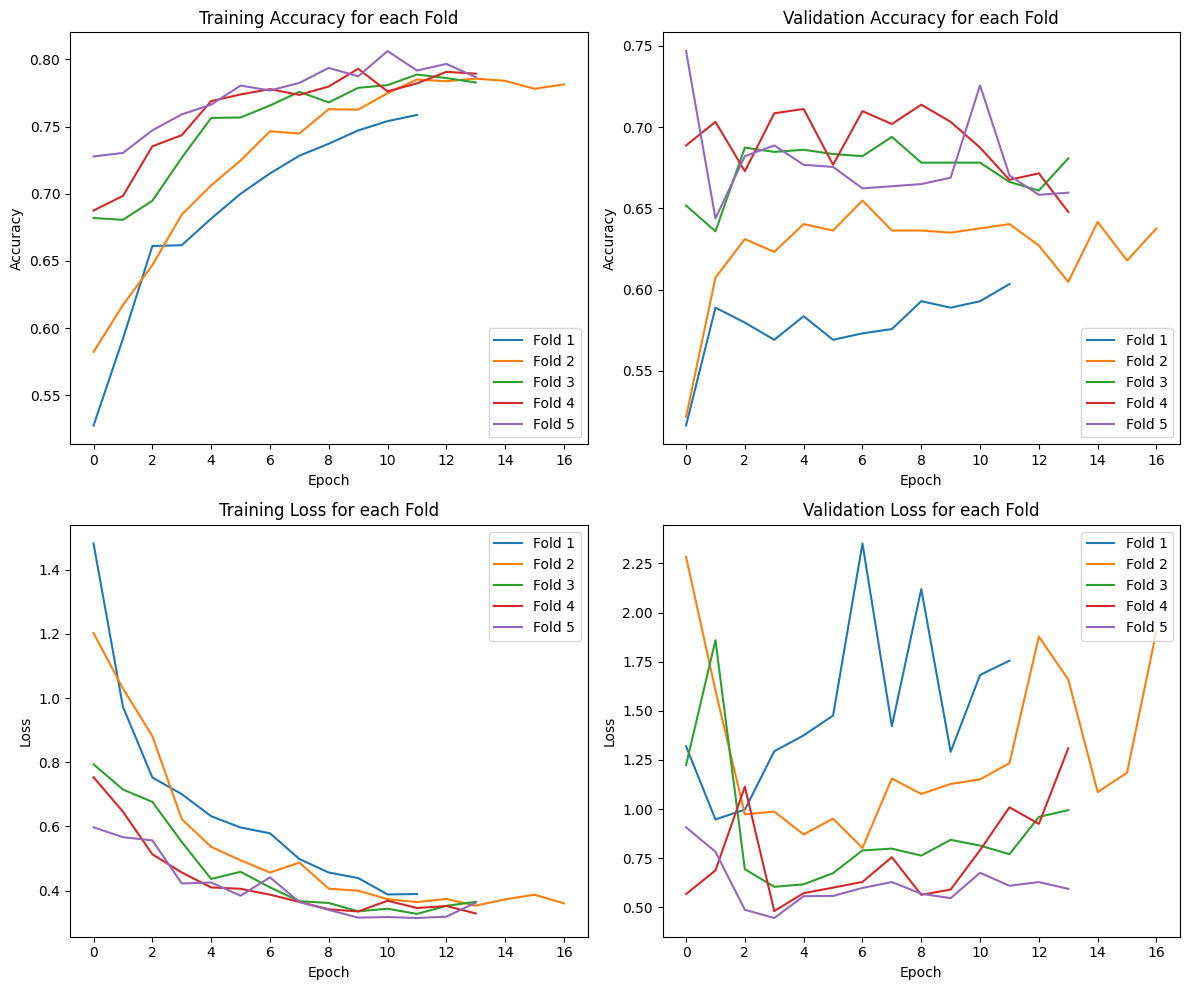

In [7]:
# Initialize lists to store accuracy and loss for each fold
accuracy_per_fold = []
val_accuracy_per_fold = []
loss_per_fold = []
val_loss_per_fold = []

mean_accuracy_per_fold = []
mean_val_accuracy_per_fold = []
mean_loss_per_fold = []
mean_val_loss_per_fold = []

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# Iterate through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    train_data_fold, val_data_fold = train_data[train_idx], train_data[val_idx]
    train_labels_fold, val_labels_fold = train_labels[train_idx], train_labels[val_idx]

    # Ensure correct shape for input tensors
    train_data_fold = train_data_fold.reshape(-1, 256, 256, 3)  # Reshape train data
    val_data_fold = val_data_fold.reshape(-1, 256, 256, 3)  # Reshape validation data
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Calculate class weights for handling class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_fold), y=train_labels_fold)
    class_weight_dict = dict(enumerate(class_weights))

    # Train your model with augmented data
    history = model.fit(
        train_data_fold,
        train_labels_fold,
        epochs=80,
        validation_data=(val_data_fold, val_labels_fold),
        callbacks=[early_stopping],
        class_weight=class_weight_dict
    )
    accuracy_per_fold.append(history.history['accuracy'])
    val_accuracy_per_fold.append(history.history['val_accuracy'])
    loss_per_fold.append(history.history['loss'])
    val_loss_per_fold.append(history.history['val_loss'])
    
    # Append mean accuracy and loss for the fold
    mean_accuracy_per_fold.append(np.mean(history.history['accuracy']))
    mean_val_accuracy_per_fold.append(np.mean(history.history['val_accuracy']))
    mean_loss_per_fold.append(np.mean(history.history['loss']))
    mean_val_loss_per_fold.append(np.mean(history.history['val_loss']))
    
    print(f"Fold {fold + 1}/{k_folds} completed.")

# Calculate average accuracy and loss for training and validation
avg_accuracy = np.mean(mean_accuracy_per_fold)
avg_val_accuracy = np.mean(mean_val_accuracy_per_fold)
avg_loss = np.mean(mean_loss_per_fold)
avg_val_loss = np.mean(mean_val_loss_per_fold)

print(f"\nAverage training accuracy over {k_folds} folds: {avg_accuracy:.4f}")
print(f"Average validation accuracy over {k_folds} folds: {avg_val_accuracy:.4f}")
print(f"Average training loss over {k_folds} folds: {avg_loss:.4f}")
print(f"Average validation loss over {k_folds} folds: {avg_val_loss:.4f}")

# Plot all four plots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot training accuracy for each fold
for i in range(k_folds):
    axs[0, 0].plot(accuracy_per_fold[i], label='Fold {}'.format(i+1))
axs[0, 0].set_title('Training Accuracy for each Fold')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc='lower right')

# Plot validation accuracy for each fold
for i in range(k_folds):
    axs[0, 1].plot(val_accuracy_per_fold[i], label='Fold {}'.format(i+1))
axs[0, 1].set_title('Validation Accuracy for each Fold')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc='lower right')

# Plot training loss for each fold
for i in range(k_folds):
    axs[1, 0].plot(loss_per_fold[i], label='Fold {}'.format(i+1))
axs[1, 0].set_title('Training Loss for each Fold')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc='upper right')

# Plot validation loss for each fold
for i in range(k_folds):
    axs[1, 1].plot(val_loss_per_fold[i], label='Fold {}'.format(i+1))
axs[1, 1].set_title('Validation Loss for each Fold')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

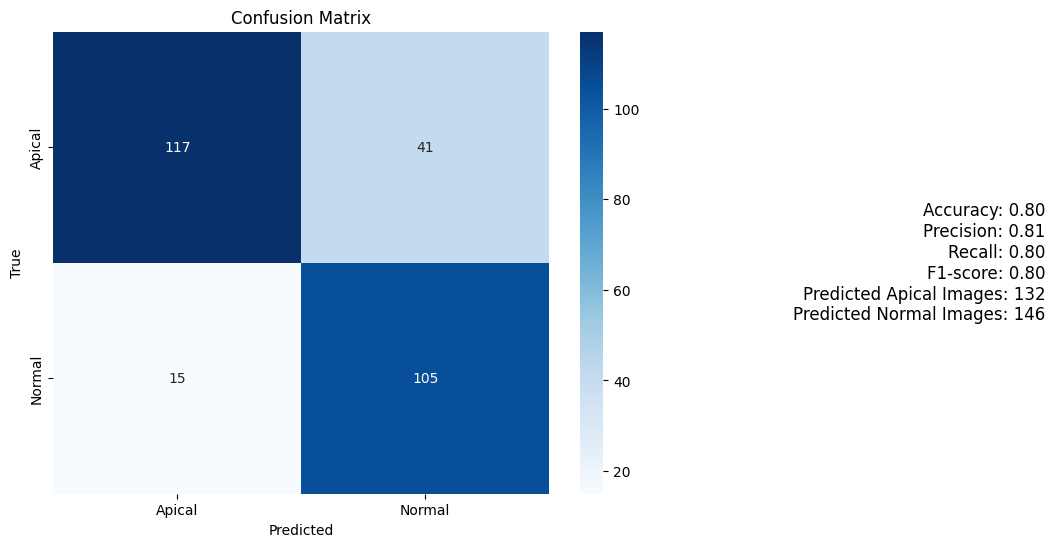

In [8]:
# Define class labels
class_labels = {0: 'Apical', 1:'Normal'}

predictions = []

# Make predictions on test data
for img_array in test_data:
    # Assuming model is defined elsewhere
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    predicted_class_index = np.argmax(prediction)
    #predicted_class = class_labels[predicted_class_index]
    predictions.append(predicted_class_index)

# Calculate metrics using test labels and predictions
cm = confusion_matrix(test_labels, predictions)
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

# Count predicted Apical and Normal images
apicals = sum(1 for pred in predictions if pred == 0)
norms = sum(1 for pred in predictions if pred == 1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Apical', 'Normal'], yticklabels=['Apical', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.text(2, 0.5, f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}\nPredicted Apical Images: {apicals}\nPredicted Normal Images: {norms}', horizontalalignment='right', verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)
plt.show()

# Weights saving

In [9]:
import torch
model.save('model1.h5')
from IPython.display import FileLink
from IPython.display import display
FileLink(r'model1.h5')

/kaggle/working/model1.h5